In [1]:
import pandas as pd
import yaml
import os
#import cv2                  #conda install conda-forge::opencv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import PIL.Image as Image
from tqdm.notebook import tqdm
%run parallel_functions.py
from parallel_functions import read_image_and_bbox, read_and_process_file
from joblib import Parallel, delayed

with open('data.yaml', 'r') as f:
    train_data = yaml.safe_load(f)
    number_classes=train_data['nc']
    classes=train_data['names']
    
train_path="./train"
val_path="./valid"

num_jobs=16

print(train_path)

def get_files(path, endswith):
    files = []
    for root, dirs, file in os.walk(path):
        for f in file:
            if f.endswith(endswith):
                files.append(f)
    return files

train_images=get_files(train_path+"/images", ".jpg")
valid_images=get_files(val_path+"/images", ".jpg")
train_labels=get_files(train_path+"/labels", ".txt")
valid_labels=get_files(val_path+"/labels", ".txt")

./train


In [2]:
def read_and_process_file(file_path):
    df = pd.read_csv(file_path, sep=" ", header=None)
    df.columns = ['class', 'x', 'y', 'w', 'h']
    df['image'] = os.path.basename(file_path).replace('.txt', '.jpg')
    df['class'] = df['class'].astype(int)
    return df

df_collection=Parallel(n_jobs=num_jobs)(delayed(read_and_process_file)(train_path+"/labels/"+file) for file in train_labels)
df=pd.concat(df_collection, ignore_index=True)

In [3]:
df_valid=pd.concat(Parallel(n_jobs=16)(delayed(read_and_process_file)(val_path+"/labels/"+file) for file in valid_labels), ignore_index=True)

In [4]:
# show rows with image 998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec077.jpg
df[df['image']=='998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec077.jpg']

class         x         y         w         h  \
52923     34  0.360577  0.737981  0.097356  0.045673   
52924      8  0.370192  0.640625  0.100962  0.048077   
52925     11  0.399038  0.538462  0.100962  0.062500   
52926     11  0.808894  0.402644  0.100962  0.063702   

                                                   image  
52923  998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec...  
52924  998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec...  
52925  998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec...  
52926  998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec...

In [5]:
# get maximum number of bounding boxes in an image
max_boxes=df['image'].value_counts().max()
max_boxes

4

In [6]:
train_path=train_path+"/images"
val_path=val_path+"/images"

In [7]:
df['class'].unique().min()

0

In [8]:
# increase all classes by 1
df['class'] = df['class']+1
df['class'].unique().min()

1

In [9]:
class_dict={}
for i in range(number_classes):
    class_dict[i+1]=classes[i]
class_dict[0]='None'
number_classes=len(class_dict)

In [10]:
import imageio
train_chunks = [group for _, group in df.groupby('image')]
valid_chunks = [group for _, group in df_valid.groupby('image')]
def read_image_and_bbox(chunck, train_path):
    image = imageio.imread(train_path+"/"+chunck.iloc[0]['image'])
    image = Image.fromarray(image)
    return {"image": image, "chunck": chunck}

train_data=Parallel(n_jobs=num_jobs)(delayed(read_image_and_bbox)(chunck, train_path) for chunck in train_chunks)
valid_data=Parallel(n_jobs=num_jobs)(delayed(read_image_and_bbox)(chunck, val_path) for chunck in valid_chunks)

In [11]:
len(train_data), len(valid_data)

(14000, 4000)

In [12]:
train_data[0]["chunck"]

class         x         y         w         h  \
0     52  0.460337  0.693510  0.064904  0.042067   
1     38  0.644231  0.501202  0.063702  0.088942   
2     38  0.614183  0.074519  0.064904  0.088942   

                                               image  
0  000090528_jpg.rf.d50e89610e5c97c61632c290692f3...  
1  000090528_jpg.rf.d50e89610e5c97c61632c290692f3...  
2  000090528_jpg.rf.d50e89610e5c97c61632c290692f3...

<Axes: >

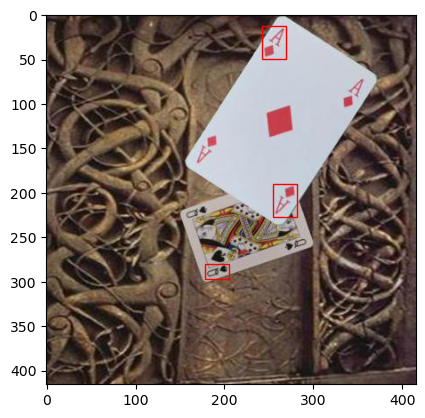

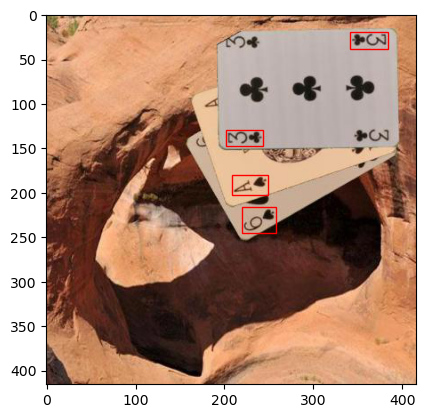

In [13]:
def show_boxes(image_data, show_class=False, ax=None):
    image=image_data['image']
    if ax is None:
        fig, ax = plt.subplots(1)
    ax.imshow(image)
    width, height = image.size
    bboxes=image_data["chunck"]
    
    for i in range(len(bboxes)):
        bbox=bboxes.iloc[i]
        x, y, w, h = bbox['x']*width, bbox['y']*height, bbox['w']*width, bbox['h']*height
        rect = patches.Rectangle((x-w/2, y-h/2), w, h, linewidth=1, edgecolor='r', facecolor='none')	
        if show_class:
            ax.text(x-w/2, y-h/2, class_dict[bbox['class']], fontsize=12, color='white', backgroundcolor='red')
        ax.add_patch(rect)
    return ax

show_boxes(train_data[0])
show_boxes(train_data[1230])

In [14]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.df = df
        self.data = data
        self.size=len(data)
        self.transform = transform
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        image = self.data[idx]["image"]
        boxes=self.data[idx]["chunck"][['x', 'y', 'w', 'h']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        target = {}
        target['boxes'] = boxes
        if len(target['boxes'])<4:
            target['boxes']=torch.cat((target['boxes'], torch.zeros(4-len(target['boxes']), 4)))
        #transform
        if self.transform:
            image = self.transform(image)
        #print("image.shape in dataset", image.shape)
        #print("target in dataset", target)
        return image, target, idx
    
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor()])
dataset = Dataset(train_data, transform)
image, target, _ = dataset[0]

print(image.shape)

print(target)

torch.Size([3, 416, 416])
{'boxes': tensor([[0.4603, 0.6935, 0.0649, 0.0421],
        [0.6442, 0.5012, 0.0637, 0.0889],
        [0.6142, 0.0745, 0.0649, 0.0889],
        [0.0000, 0.0000, 0.0000, 0.0000]])}


In [15]:
import torchvision
from torchvision.models import ResNet50_Weights

class Model(torch.nn.Module):
    def __init__(self, hidden_size=None, dropout=0.4):
        super().__init__()
        self.backbone=torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone_output_size=1000
        number_boxes=4
        self.neurons_per_box=4      
        output_neurons=number_boxes*self.neurons_per_box
        
        self.head=torch.nn.Sequential(
            torch.nn.Linear(self.backbone_output_size, hidden_size),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Linear(hidden_size, output_neurons),
            torch.nn.Sigmoid()
        )
              
        # freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.freezed_backbone=True
        
            
    def unfreeze_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = True
        self.freezed_backbone=False
        
    def get_backbone_layer(self, number):
        if number==1:
            return self.backbone.layer1
        if number==2:
            return self.backbone.layer2
        if number==3:
            return self.backbone.layer3
        if number==4:
            return self.backbone.layer4
 
    def forward(self, x):
        x=self.backbone(x)
        x=x.view(-1, self.backbone_output_size)
        x=self.head(x)
        return x
    
model=Model(hidden_size=100)
loader=torch.utils.data.DataLoader(dataset, batch_size=13, shuffle=True)
for image, target, _ in loader:
    print(image.shape)
    output=model(image)
    assert output.shape[0]==13, "batch size is not correct, its "+str(output.shape[0])
    print(output.shape) 
    break


torch.Size([13, 3, 416, 416])
torch.Size([13, 16])


In [16]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import torch.nn.functional as F


objectness_loss_fn=torch.nn.BCELoss()

def loss_fun(output, target):
    number_boxes=4
    neurons_per_box=4
    output=output.view(-1, number_boxes, neurons_per_box)
    target_boxes=target['boxes']
    mse=torch.nn.MSELoss()
    mse_loss=mse(output[:, :, :4], target_boxes)                            
    return mse_loss, {'mse_loss':mse_loss.item()}
    

In [17]:
def get_validation_loss(model, loader, loss_fun):
    model.eval()
    with torch.no_grad():
        loss_sum=0
        detailed_losses={'mse_loss':0, 'objectness_loss':0}
        for image, target,_ in loader:
            image=image.to(device)
            target['boxes']=target['boxes'].to(device)
            output=model(image)
            loss, detailed_loss=loss_fun(output, target)
            loss_sum+=loss
            detailed_losses['mse_loss']+=detailed_loss['mse_loss']
        detailed_losses['mse_loss']=detailed_losses['mse_loss']/len(loader)
        return loss_sum.item()/len(loader), detailed_losses

In [18]:
import neptune



In [19]:
import time

def train(epochs, lr, steps_valid=50, optimizer=None, model=None, loader=None, loader_valid=None, loss_fun=None, neptune_run=None, unfreeze_backbone_n_epoch=None):
    model.train()
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(loader), epochs=epochs)
    postfix={}
    step=0
    last_valid_loss=100
    for epoch in range(epochs):
        if unfreeze_backbone_n_epoch and epoch==unfreeze_backbone_n_epoch:
            model.unfreeze_backbone()
        bar=tqdm(loader, leave=False)
        bar.set_description(f"Epoch {epoch+1}/{epochs}")
        bar.set_postfix(postfix)
        for image, target, _ in bar:
            model.train()
            optimizer.zero_grad()
            bar.update(1)
            current_timer=time.time()
            image=image.to(device)
            target['boxes']=target['boxes'].to(device)
            output=model(image)
            loss, detailed_loss=loss_fun(output, target)
            loss.backward()
            optimizer.step()
            neptune_run["train/loss"].log(loss.item())
            neptune_run["train/mse_loss"].log(detailed_loss['mse_loss'])
            step+=1
        
            if step%steps_valid==0:
                print("step", step)
                print("steps_valid", steps_valid)
                valid_loss, detailed_losses=get_validation_loss(model, loader_valid, loss_fun)
                neptune_run["valid/loss"].log(valid_loss)
                neptune_run["valid/mse_loss"].log(detailed_losses['mse_loss'])
                last_valid_loss=valid_loss
            scheduler.step()
            postfix={
                'loss': loss.item(),
                'mse_loss': detailed_loss['mse_loss'],
                'valid_loss': last_valid_loss,
                'lr':scheduler.get_last_lr()[0]
            }
            neptune_run["train/lr"].log(scheduler.get_last_lr()[0])
            bar.set_postfix(postfix)

In [20]:
del model
torch.cuda.empty_cache()


hidden_size=300
lr=0.0001
wd=0.0001
bs=56
epochs=5
unfreeze_backbone_n_epoch=2
steps_per_epoch=len(loader)
steps_valid=steps_per_epoch//4


model=Model(hidden_size=hidden_size)
model.to(device)

print("steps per epoch", steps_per_epoch)
print("steps valid", steps_valid)
optimizer=torch.optim.AdamW([
    {'params': model.head.parameters(), 'lr':lr}, 
    {'params': model.get_backbone_layer(4).parameters(), 'lr':lr/10}, 
    {'params': model.get_backbone_layer(3).parameters(), 'lr':lr/10}, 
    {'params': model.get_backbone_layer(2).parameters(), 'lr':lr/100}, 
    {'params': model.get_backbone_layer(1).parameters(), 'lr':lr/100}],
weight_decay=wd)
    
#optimizer=torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=wd)
loader=torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
loader_valid=torch.utils.data.DataLoader(Dataset(valid_data, transform), batch_size=bs, shuffle=True)

run = neptune.init_run(
    project="bernd.heidemann/cards-detection",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzNjBlYzVkNi0zZTUwLTQ1ODYtODhlNC02NDUxNDg0MDdjNzUifQ==",
)  # your credentials
params = {
    "learning_rate": lr, 
    "optimizer": "AdamW", 
    "weight_decay": wd,
    "batch_size": bs,
    "epochs": epochs,
    "unfreeze_backbone_n_epoch": unfreeze_backbone_n_epoch,
    "hidden_size": hidden_size
}
run["parameters"] = params
loss_fn=loss_fun

train(epochs, lr, steps_valid=steps_valid, optimizer=optimizer, model=model, loader=loader, loader_valid=loader_valid, loss_fun=loss_fn, neptune_run=run, unfreeze_backbone_n_epoch=unfreeze_backbone_n_epoch)


steps per epoch 1077
steps valid 269


c:\Users\Bernd\anaconda3\envs\mytorch\lib\site-packages\neptune\common\warnings.py:71: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  warnings.warn(


https://app.neptune.ai/bernd.heidemann/cards-detection/e/CAR-41


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [21]:
print("steps per epoch", steps_per_epoch)
print("steps valid", steps_valid)

steps per epoch 1077
steps valid 269


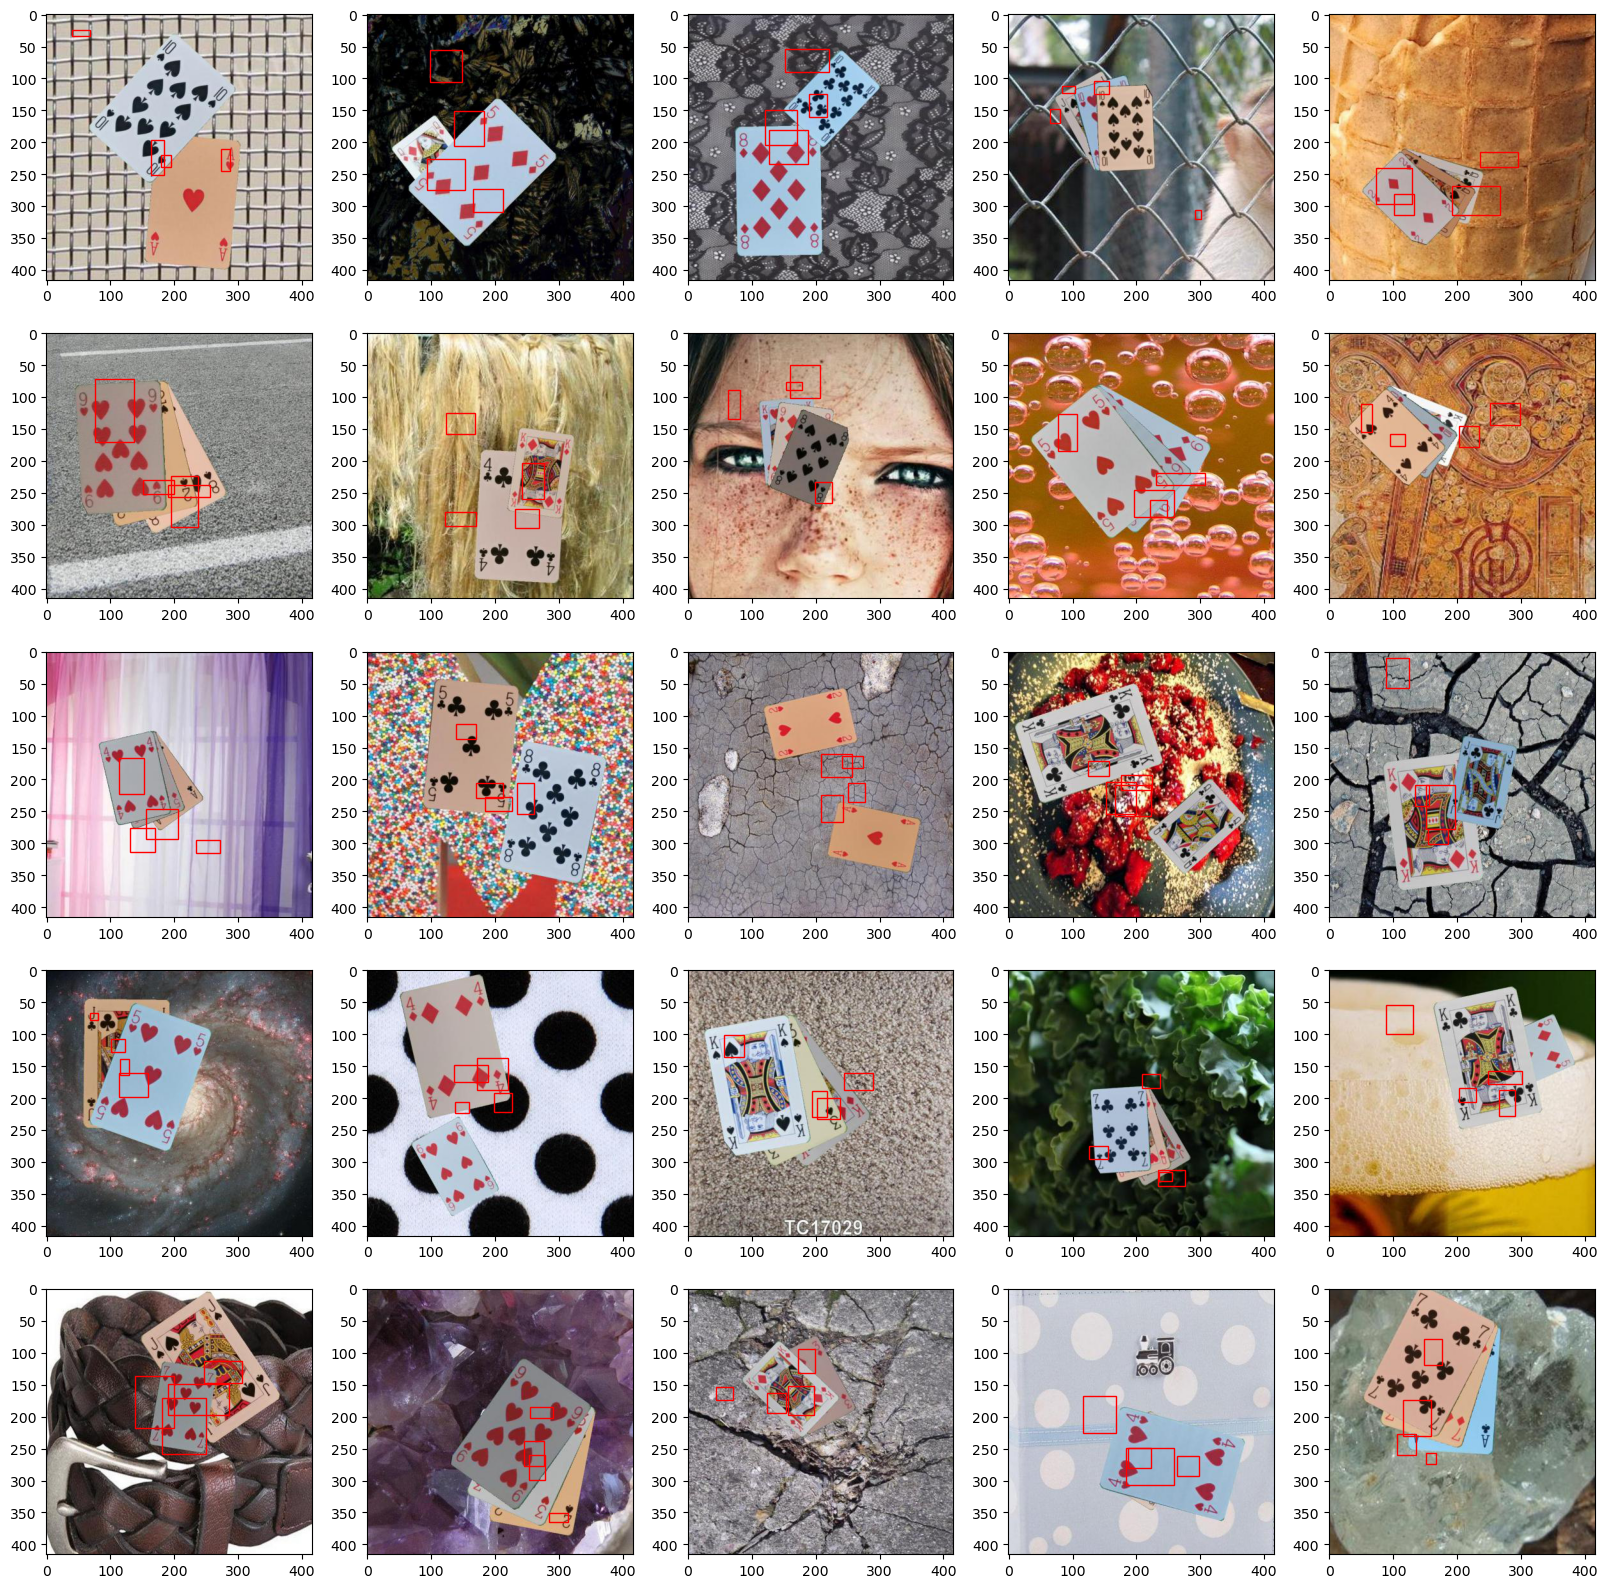

In [22]:
sample={}

loader_valid=torch.utils.data.DataLoader(Dataset(valid_data, transform), batch_size=32, shuffle=True)
cols=['x', 'y', 'w', 'h']
output_data=[]
for xb, yb, idx in loader_valid:
    xb=xb.to(device)
    yb['boxes']=yb['boxes'].to(device)
    output=model(xb)
    for i in range(output.shape[0]):
        # create image from xb tensor
        image=xb[i].detach().cpu().numpy().transpose(1,2,0)
        # convert to PIL
        image=Image.fromarray((image*255).astype(np.uint8))
        df_chunk=pd.DataFrame(columns=cols)
        for j in range(4):            
            x,y,w,h=output[i, j*4:(j+1)*4].detach().cpu().numpy()
            df_chunk.loc[j]=[x,y,w,h]
        output_data.append({
                'image': image,
                'chunck': df_chunk
            })
    break





fig, ax=plt.subplots(5, 5, figsize=(20, 20))
for row in range(5):
    for col in range(5):
        show_boxes(output_data[row*5+col], show_class=False, ax=ax[row, col])
plt.show()
